In [1]:
import os
import re 
import csv
import nltk
import string
import fasttext
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from multiprocessing import Pool, cpu_count
from sklearn.model_selection import train_test_split

Make sure you have downloaded your Kaggle token on your local machine (you can follow step 1 in this [tutorial](https://medium.com/@yvettewu.dw/tutorial-kaggle-api-google-colaboratory-1a054a382de0)). You will get a `kaggle.json` file that you can open with your favorite text editor. You will be able to see something like this:
`{“username”:”YOUR-USER-NAME”,”key”:”SOMETHING-VERY-LONG”}`. Next, you can copy and paste your username and key in the following cell so you can configure appropiate credentials to download the data in the next steps.

In [ ]:
os.environ["KAGGLE_USERNAME"] = "YOUR-USER-NAME"
os.environ["KAGGLE_KEY"] = "SOMETHING-VERY-LONG"

# 1. Get the data

In [3]:
! kaggle datasets download stackoverflow/stacksample

100%|██████████████████████████████████████| 1.11G/1.11G [01:53<00:00, 10.7MB/s]



Make directories and unzip downloaded files.

In [4]:
%%bash
mkdir stacksample
unzip -j stacksample.zip Questions.csv -d stacksample/ 
unzip -j stacksample.zip Tags.csv -d stacksample/
rm stacksample.zip
mkdir data models predictions

Archive:  stacksample.zip
  inflating: stacksample/Questions.csv  
Archive:  stacksample.zip
  inflating: stacksample/Tags.csv    


# 2. Preparing the data

We begin by loading the data (both the Questions and Tags tables) by chunks. We have followed the same approach as in [Yi Ai's](https://medium.com/@yia333) [Medium post](https://medium.com/hackernoon/auto-generating-tags-for-content-using-amazon-sagemaker-blazingtext-with-fasttext-335c38429de0).

In [5]:
QuestionsFile = "stacksample/Questions.csv"
chunksize = 20000

df = None
for ratings in pd.read_csv(QuestionsFile, names=['id', 'title', 'body'], encoding = 'ISO-8859-1',  header=None , usecols=[0,5,6],error_bad_lines = False, chunksize=chunksize):
    if df is None:
        df = ratings.copy()
    else:
        df.append(ratings)
        
TagsFile = "stacksample/Tags.csv"
chunksize = 20000
df_tags = None
for ratings in pd.read_csv(TagsFile, names=['id', 'tag'], header=None , chunksize=chunksize):
    if df_tags is None:
        df_tags = ratings.copy()
    else:
        df_tags.append(ratings)

# 3. (Quick) Data Exploration & Visualization

Let's compute statistics over the frequency counts of the *tag* field in the tags dataframe.

In [6]:
df_tags.tag.value_counts(normalize=False,sort=True,ascending=False).to_frame().describe()

,tag
count,3506.000000
mean,5.702510
std,27.213578
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,862.000000


Let's plot a histogram over the top-100 most frequent tags.

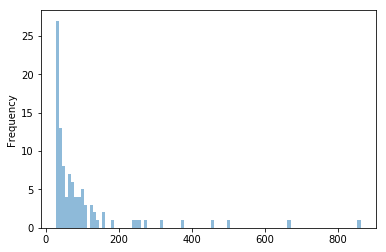

In [7]:
df_tags.tag.value_counts(normalize=False,sort=True,ascending=False).head(100).plot.hist(bins=100, alpha=0.5)

Create a dataframe with tags and frequency counts with the top-100 most frequent tags.

In [8]:
mytags = df_tags.tag.value_counts(normalize=False,sort=True,ascending=False).to_frame().head(100).reset_index()

Let's compute statistics as before, for the subset of the top-100 most frequent tags.

In [9]:
mytags.describe()

,tag
count,100.000000
mean,99.230000
std,128.606506
min,29.000000
25%,37.000000
50%,56.000000
75%,98.250000
max,862.000000


### Wordcloud of the top-100 most frequent tags

In [10]:
d = {}
for a, x in mytags.values:
    d[a] = x

In [11]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    random_state=12345,
    background_color = 'black').generate_from_frequencies(frequencies=d)

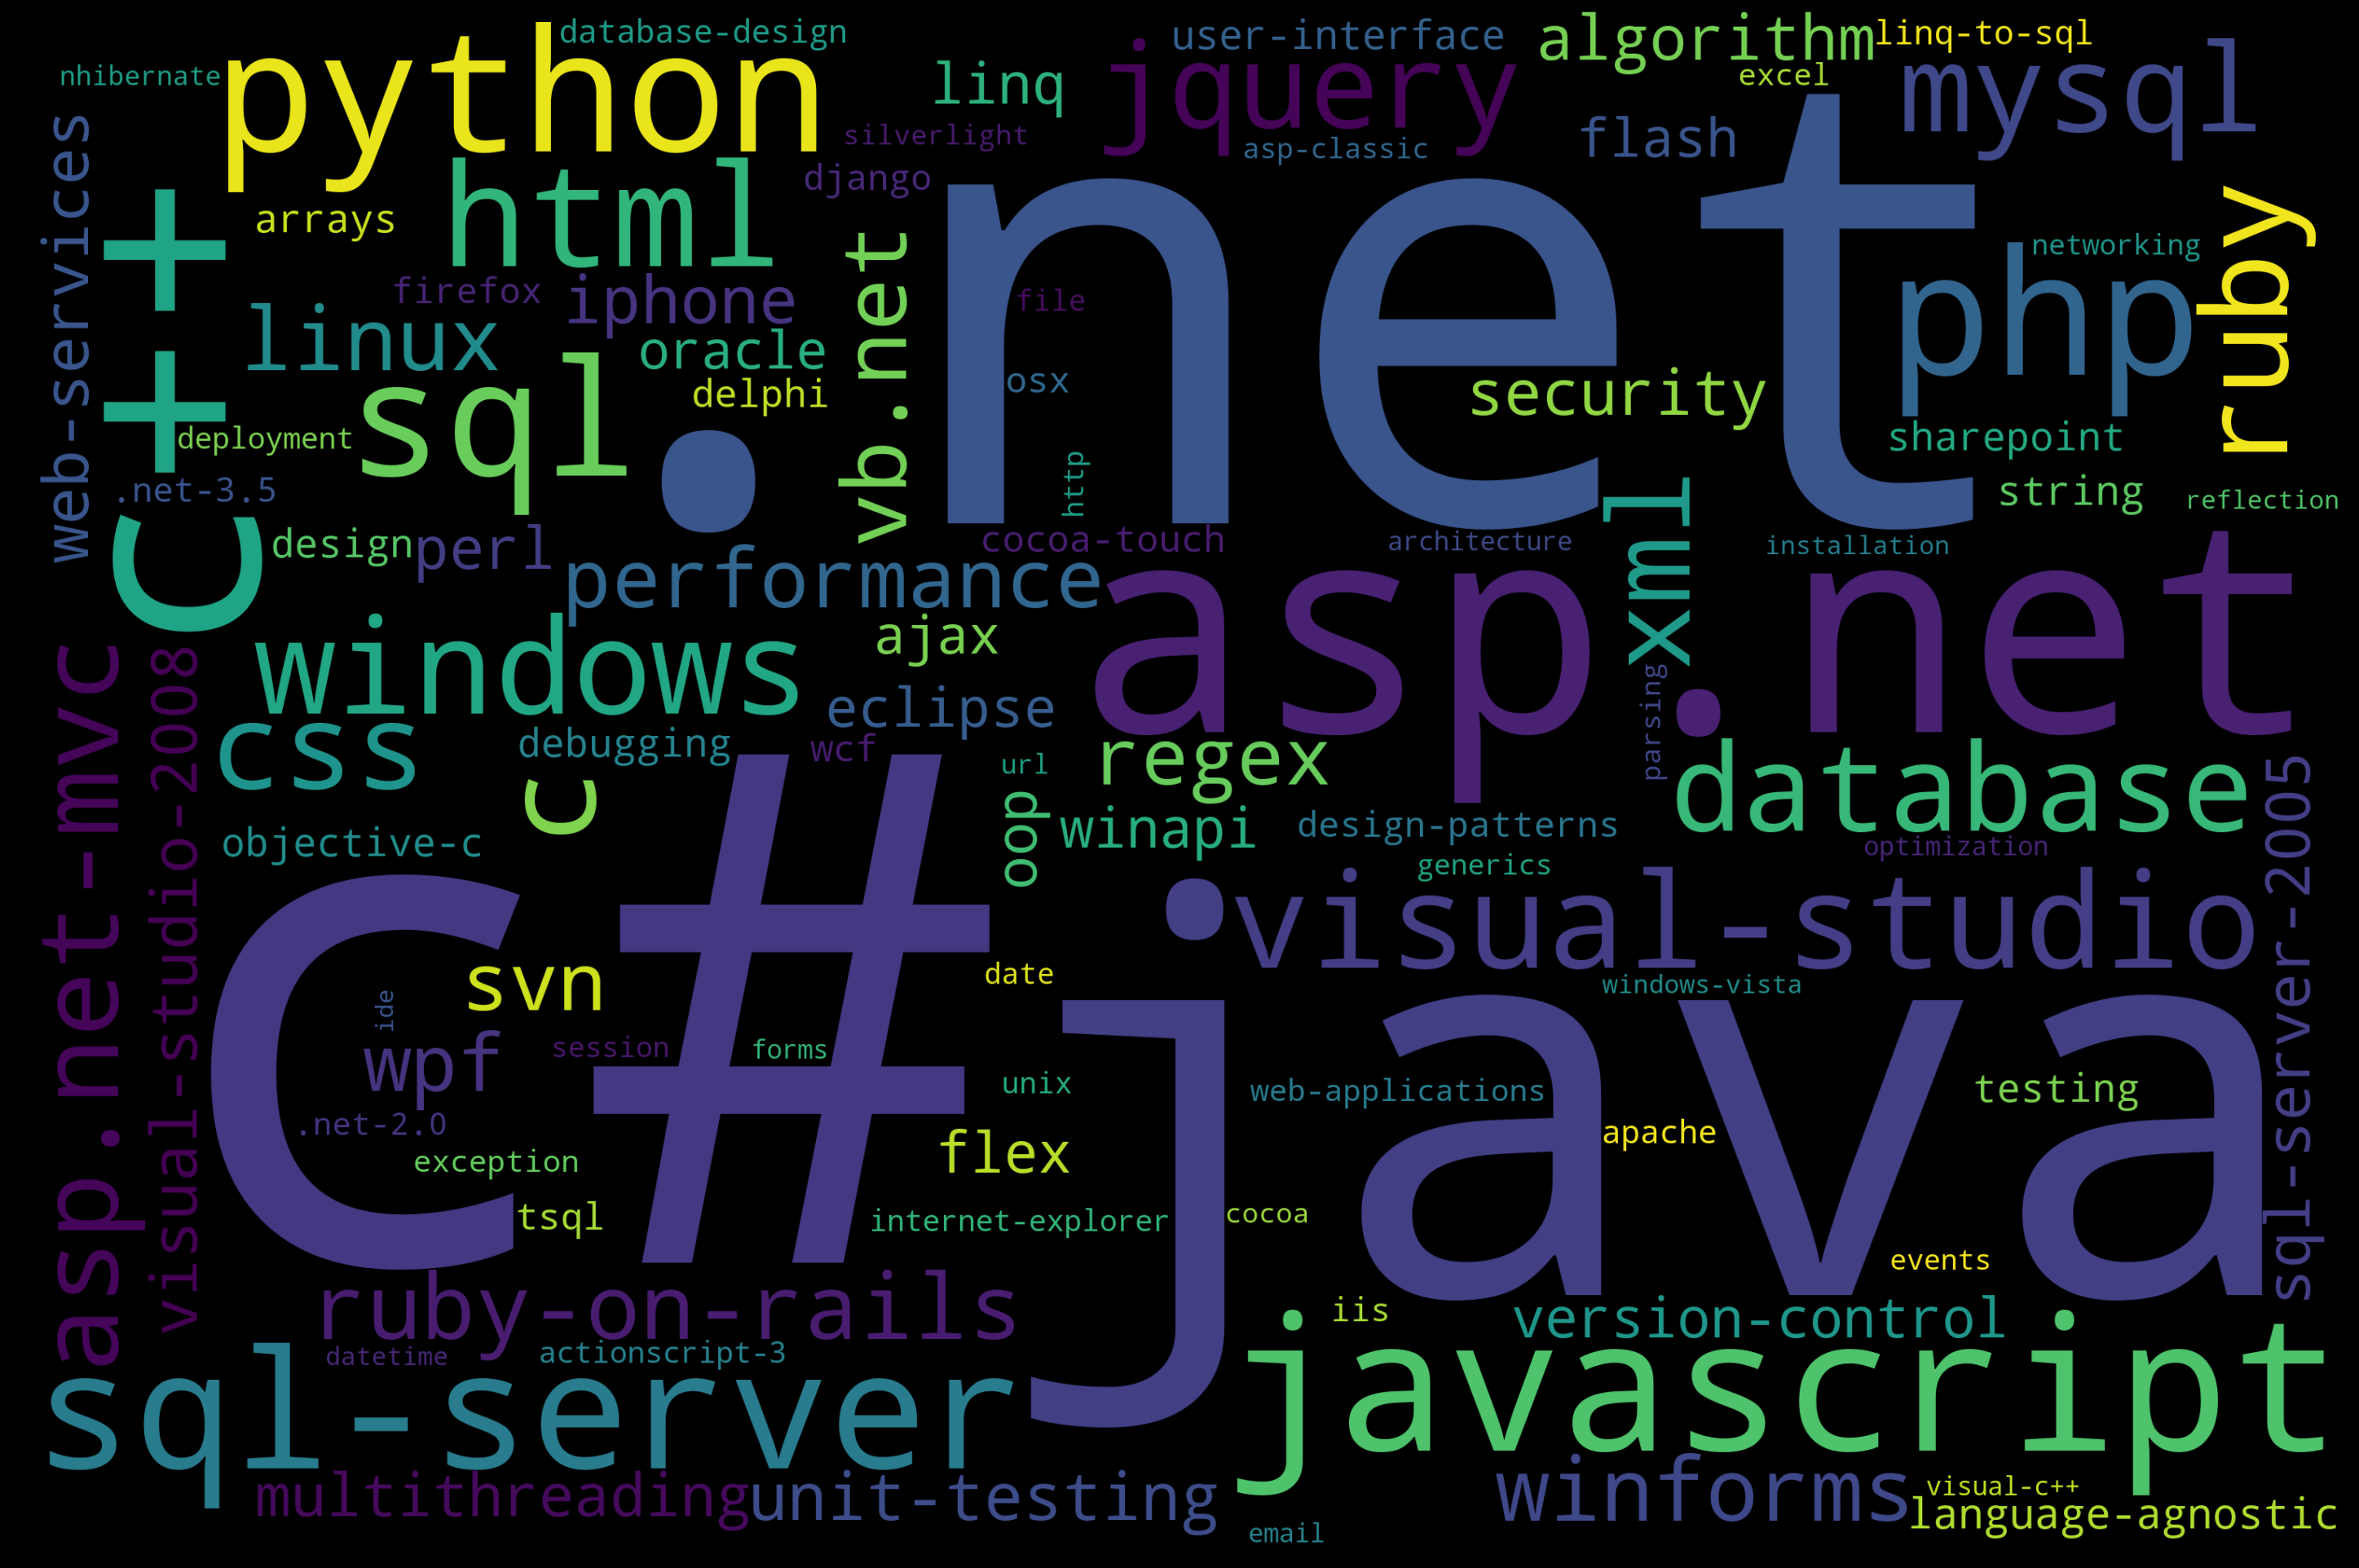

In [12]:
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
fig.savefig('toptags.png', dpi=fig.dpi)

Let's store the top-100 most frequent tags in a list.

In [13]:
topTags = df_tags.tag.value_counts(normalize=False,sort=True,ascending=False).head(100).index.tolist()

Let's filter the tags dataframe based on the previous list.

In [14]:
df_tags = df_tags[df_tags.tag.isin(topTags)]

# 4. Processing the data

For both fastText and StarSpace (and Amazon's [BlazingText](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html) too!), the input file has to be formatted in a way that each line contain a single sentence and the corresponding label(s) prefixed by __label__, e.g.  

``__label__database __label__oracle How to edit sessions parameters on Oracle 10g XE?``. 

Additionally, the input data has to be as clean as possible. The following function generates a preprocessed and clean data after removing HTML tags and unwanted punctuations. 

For both steps, we have followed the same approach as in [Yi Ai's](https://medium.com/@yia333) [Medium post](https://medium.com/hackernoon/auto-generating-tags-for-content-using-amazon-sagemaker-blazingtext-with-fasttext-335c38429de0). The following functions perform the aforementioned steps.

In [15]:
def clean_text(text):
    if not isinstance(text, str): 
        return text
    def cleanhtml(raw_html):
        cleanr = re.compile('<[^>]+>')
        cleantext = re.sub(cleanr, '', raw_html)
        return cleantext
    def replace_link(match):
        return '' if re.match('[a-z]+://', match.group(1)) else match.group(1)
    def removeContractions(raw_text):
        CONTRACTIONS = {"mayn't":"may not", "may've":"may have","isn't":"is not","wasn't":"was not","'ll":" will","'have": "have"}
        raw_text = raw_text.replace("’","'")
        words = raw_text.split()
        reformed = [CONTRACTIONS[word] if word in CONTRACTIONS else word for word in words]
        raw_text = " ".join(reformed)
        return raw_text
    text = cleanhtml(text)
    text = removeContractions(text)
    text = re.sub('<pre><code>.*?</code></pre>', '', text)
    text = re.sub('<a[^>]+>(.*)</a>', replace_link, text)
    #Remove hashtags
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", text).split())
    #Remove punctuations
    text = ' '.join(re.sub("[\.\,\(\)\{\}\[\]\`\'\!\?\:\;\-\=]", " ", text).split())
    #text = text.translate(str.maketrans('','',string.punctuation))
    text = text.lower()
    return text

In [16]:
questions = df.values
tags = df_tags.values

all_rows=[]

for index, row in enumerate(questions):
    title = clean_text(row[1])
    tag_ids = [ tag[1] for tag_idx, tag in enumerate(tags) if tag[0]  == row[0] ]
    if(len(tag_ids)>0): 
        all_rows.append({"title":title, "tags":tag_ids})

In [17]:
nltk.download('punkt')

def preprocess(rows,output_file):
    pool = Pool(processes=cpu_count())
    transformed_rows = pool.map(transform_instance, rows)
    pool.close() 
    pool.join()
    with open(output_file, "w") as txt_file:
        for line in transformed_rows:
            txt_file.write(" ".join(line) + "\n")
            
def transform_instance(row):
    cur_row = []
    label = ["__label__" + str(tag) for tag in row["tags"] if tag]
    label = " ".join(map(str, label))
    cur_row.append(str(label))
    cur_row.extend(nltk.word_tokenize(row["title"]))
    return cur_row

[nltk_data] Downloading package punkt to /Users/pjcv89/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 5. Create training, validation and test sets and store them in local directory

## For fastText and StarSpace models

Apply the previous defined functions and split the data pseudorandomly on train, validation and test sets.

In [18]:
train, valid = train_test_split(all_rows,test_size=0.20,random_state=12345)
valid, test = train_test_split(valid,test_size=0.50,random_state=12345)

preprocess(train, 'data/train')    
preprocess(valid, 'data/valid')
preprocess(test, 'data/test')

In [19]:
pdf_test = pd.DataFrame(test).explode('tags')

We can see how our test data looks like after exploding the *tags* column.

In [20]:
pdf_test.head(10)

,title,tags
0,what are the benefits to marking a field as re...,c#
1,is it ok to return a keyvaluepair from a net f...,.net
2,how do i split a string on a fixed character s...,java
2,how do i split a string on a fixed character s...,string
3,how to set wpf s grid rowdefinitions via style,wpf
4,find java classes implementing an interface,java
5,accessing stored structures for which i have a...,c++
5,accessing stored structures for which i have a...,xml
6,difference between user control and custom con...,asp.net
7,implementing a search page using url parameter...,asp.net


# 6. Building the models

Before training and using the models for predictions, let's take our test set and make a list with the true tags for each instance in the set. We are going to collect predictions for each model and append a new column to this dataframe with the corresponding predictions each time. In order to simplify the analysis, suppose we want to retrieve the top-3 predictions for each model. At the end, we will compute metrics per instance ([precision@k and recall@k](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Precision_at_K)) with $k=3$ predictions per model and we will be able to compute statistics to compare models.

In [21]:
indexes = pdf_test.title.unique()
grouped = pdf_test.groupby('title').apply(lambda x: list(x.tags)).to_frame().reindex(indexes) \
                .reset_index().rename(columns={0: "true"})
grouped['n_tags'] = grouped['true'].apply(lambda x: len(x))

Let's take a small sample. This will be our working sample to show predictions for each model from now on.

In [22]:
grouped[grouped['n_tags']>2].sample(15,random_state=12345).drop(columns='n_tags')

,title,true
297,how can i add sessions to my perl web app,"[perl, web-applications, session]"
313,parsing exact dates in c# shouldn t force you ...,"[c#, .net, datetime, parsing]"
175,is there a perl equivalent of python s re find...,"[python, regex, perl]"
457,persistence solutions for c++ with a sql database,"[c++, sql, database]"
494,what s a good way to check if two datetimes ar...,"[sql, sql-server, tsql, datetime]"
448,create a search engine with sql 2000 and asp n...,"[c#, asp.net, sql-server]"
49,access to result sets from within stored proce...,"[sql, sql-server, tsql]"
165,asp net iis service unavailable,"[asp.net, .net, iis]"
528,dragging an image in wpf,"[.net, wpf, user-interface]"
37,unit tests framework for databases,"[sql-server, database, unit-testing]"


## 6.1 fastText: Baseline

We can use the fastText's Python API to build a quick baseline. Let's hardcode some parameters. Please refer to the official [tutorial](https://github.com/facebookresearch/fastText/blob/master/docs/supervised-tutorial.md) for more information and examples. Also please refer to the full [list of options](https://fasttext.cc/docs/en/options.html) to see all available arguments.

In [23]:
ft_baseline = fasttext.train_supervised(input="data/train", lr=0.1, epoch=10, wordNgrams=1,dim=100)

Note that we can compute average *precision@k* and *recall@k* over the test set using fastText built-in tool for metrics.

In [24]:
[ft_baseline.test("data/test",k=i) for i in range(1,5)]

[(592, 0.3952702702702703, 0.23122529644268774),
 (592, 0.26182432432432434, 0.30632411067193677),
 (592, 0.19594594594594594, 0.3438735177865613),
 (592, 0.16005067567567569, 0.37450592885375494)]

Let's make it with a neater format.

In [25]:
metrics = pd.DataFrame([ft_baseline.test("data/test",k=i) for i in range(1,5)]) \
            .rename(columns={'index':'at',0:'n',1:'precision',2:'recall'}) \
            .drop(columns=['n'])
metrics.index=metrics.index+1
metrics = metrics.rename('at_{}'.format)
display(metrics)

,precision,recall
at_1,0.395270,0.231225
at_2,0.261824,0.306324
at_3,0.195946,0.343874
at_4,0.160051,0.374506


If we want to persist this model we can do it by using its *save_model* method.

In [26]:
ft_baseline.save_model("models/ft_baseline.bin")
del ft_baseline

And we can load it using fastText's load_model function.

In [27]:
ft_baseline = fasttext.load_model("models/ft_baseline.bin")

Let's define a function to perform predictions and get the top-3 most probable tags for each instance of the test set.

In [28]:
def get_FTpredictions(model,sentence,threshold=None,k=3):
    if threshold:
        labels, probs = model.predict(sentence.lower(),k=k)
        candidates = [labels[index]  for index in range(0,k) if probs[index] >= threshold]
    else:
        candidates = model.predict(sentence.lower(),k=k)[0]
    output = [candidate.replace("__label__","") for candidate in candidates]
    return output

Apply the previous function over the *title* field in the test set to get the predictions.

In [29]:
grouped['ft_baseline'] = grouped.title.apply(lambda sentence: get_FTpredictions(ft_baseline,sentence))

Let's take a look to predictions on our small sample.

In [30]:
grouped[grouped['n_tags']>2].sample(15,random_state=12345).drop(columns='n_tags')

,title,true,ft_baseline
297,how can i add sessions to my perl web app,"[perl, web-applications, session]","[c#, .net, asp.net]"
313,parsing exact dates in c# shouldn t force you ...,"[c#, .net, datetime, parsing]","[c#, .net, c++]"
175,is there a perl equivalent of python s re find...,"[python, regex, perl]","[python, c++, java]"
457,persistence solutions for c++ with a sql database,"[c++, sql, database]","[c++, sql, sql-server]"
494,what s a good way to check if two datetimes ar...,"[sql, sql-server, tsql, datetime]","[c++, python, java]"
448,create a search engine with sql 2000 and asp n...,"[c#, asp.net, sql-server]","[asp.net, .net, sql-server]"
49,access to result sets from within stored proce...,"[sql, sql-server, tsql]","[sql-server, sql, sql-server-2005]"
165,asp net iis service unavailable,"[asp.net, .net, iis]","[asp.net, asp.net-mvc, .net]"
528,dragging an image in wpf,"[.net, wpf, user-interface]","[.net, javascript, c#]"
37,unit tests framework for databases,"[sql-server, database, unit-testing]","[java, c++, php]"


##  6.2 fastText: Tuned model

Current version of fastText's Python API stored in PyPI (0.9.1 version, as of March 2020) doesn't support the hyperparameter autotuning tool yet. However, CLI does and that is why we downloaded both API's. We can use the autotune in the following way. Please note that we can fix a specific hyperaparameter (in this example, the embedding dimension `dim`), and also we can constrain the model size via `autotune-modelsize` parameter, since it is also a hyperparameter! We also need to provide a time constraint in seconds via the `autotune-duration` parameter.

Please refer to the [documentation](https://fasttext.cc/docs/en/autotune.html) for more information and more and examples. Also if you want to know more about what is going on under the hood, please refer to this [entry](https://ai.facebook.com/blog/fasttext-blog-post-open-source-in-brief/) in FAIR's site.

In [31]:
! fastText/build/fasttext supervised \
-input data/train \
-autotune-validation data/valid \
-output models/ft_tuned \
-dim 100 \
-autotune-duration 900 \
-autotune-modelsize 10M 

Progress: 100.0% Trials:   19 Best score:  0.470069 ETA:   0h 0m 0ssm17s Best score:   unknown ETA:   0h13m48s43s   1 Best score:   unknown ETA:   0h13m42s  0h13m11sm20sm42s11m 1sh10m45s0h10m26s59s0h 9m34s 9m12s% Trials:   10 Best score:  0.342785 ETA:   0h 9m 6s ETA:   0h 8m47sm45s 0.342785 ETA:   0h 8m40sm43s Trials:   11 Best score:  0.342785 ETA:   0h 7m39ss13sm 4s Best score:  0.342785 ETA:   0h 6m44sm43s 6m 9s 5m58s48s 0.454946 ETA:   0h 4m42s  0h 4m40s 83.8% Trials:   17 Best score:  0.458727 ETA:   0h 2m25sm57s1m38sh 1m10sm 6sh 1m 0s  0h 0m45s 0.470069 ETA:   0h 0m40s  0h 0m12s
Training again with best arguments
Read 0M words
Number of words:  5631
Number of labels: 100
Progress: 100.0% words/sec/thread:  161725 lr:  0.000000 avg.loss:  1.032029 ETA:   0h 0m 0s  0h 0m 0s
Progress: 100.0% words/sec/thread:  168979 lr:  0.000000 avg.loss:  0.853754 ETA:   0h 0m 0s


The tuned model is persisted in the specified location. We can load it as before so we can use it interactively here.

In [32]:
ft_tuned = fasttext.load_model("models/ft_tuned.ftz")

Let's see the metrics as before.

In [33]:
metrics = pd.DataFrame([ft_tuned.test("data/test",k=i) for i in range(1,5)]) \
            .rename(columns={'index':'at',0:'n',1:'precision',2:'recall'}) \
            .drop(columns=['n'])
metrics.index=metrics.index+1
metrics = metrics.rename('at_{}'.format)
display(metrics)

,precision,recall
at_1,0.633446,0.370553
at_2,0.432432,0.505929
at_3,0.324324,0.569170
at_4,0.261824,0.612648


Get predictions.

In [34]:
grouped['ft_tuned'] = grouped.title.apply(lambda sentence: get_FTpredictions(ft_tuned,sentence))

Take a look to predictions.

In [35]:
grouped[grouped['n_tags']>2].sample(20,random_state=12345).drop(columns='n_tags')

,title,true,ft_baseline,ft_tuned
297,how can i add sessions to my perl web app,"[perl, web-applications, session]","[c#, .net, asp.net]","[perl, asp.net-mvc, wpf]"
313,parsing exact dates in c# shouldn t force you ...,"[c#, .net, datetime, parsing]","[c#, .net, c++]","[date, datetime, java]"
175,is there a perl equivalent of python s re find...,"[python, regex, perl]","[python, c++, java]","[perl, python, regex]"
457,persistence solutions for c++ with a sql database,"[c++, sql, database]","[c++, sql, sql-server]","[c++, sql-server, sql]"
494,what s a good way to check if two datetimes ar...,"[sql, sql-server, tsql, datetime]","[c++, python, java]","[security, java, algorithm]"
448,create a search engine with sql 2000 and asp n...,"[c#, asp.net, sql-server]","[asp.net, .net, sql-server]","[asp.net, c#, sql-server]"
49,access to result sets from within stored proce...,"[sql, sql-server, tsql]","[sql-server, sql, sql-server-2005]","[sql-server, sql, tsql]"
165,asp net iis service unavailable,"[asp.net, .net, iis]","[asp.net, asp.net-mvc, .net]","[asp.net, iis, .net]"
528,dragging an image in wpf,"[.net, wpf, user-interface]","[.net, javascript, c#]","[wpf, user-interface, silverlight]"
37,unit tests framework for databases,"[sql-server, database, unit-testing]","[java, c++, php]","[unit-testing, testing, java]"


## 6.3 StarSpace: no label weights

StarSpace's syntax is very similar to fastText's. Please refer to StarSpace's repo. [README](https://github.com/facebookresearch/StarSpace/blob/master/README.md) for more information. Since our problem is one of text classification, we use *trainMode = 0*. To see the full list of available arguments you can just type `Starspace/starspace` in the command line.

In [36]:
! Starspace/starspace 

Usage: need to specify whether it is train or test.

"starspace train ..."  or "starspace test ..."

The following arguments are mandatory for train: 
  -trainFile       training file path
  -model           output model file path

The following arguments are mandatory for test: 
  -testFile        test file path
  -model           model file path

The following arguments for the dictionary are optional:
  -minCount        minimal number of word occurences [1]
  -minCountLabel   minimal number of label occurences [1]
  -ngrams          max length of word ngram [1]
  -bucket          number of buckets [2000000]
  -label           labels prefix [__label__]

The following arguments for training are optional:
  -initModel       if not empty, it loads a previously trained model in -initModel and carry on training.
  -trainMode       takes value in [0, 1, 2, 3, 4, 5], see Training Mode Section. [0]
  -fileFormat      currently support 'fastText' and 'labelDoc', see File Format Section. [fast

Train a model the standard way, without label weights.

In [37]:
! Starspace/starspace train \
-trainMode 0 \
-trainFile data/train \
-validationFile data/valid \
-useWeight 0 \
-model models/ss_unweighted \
-loss softmax \
-lr 0.1 \
-epoch 10 \
-batchSize 1 \
-ngrams 1 \
-adagrad 0

Arguments: 
lr: 0.1
dim: 100
epoch: 10
maxTrainTime: 8640000
validationPatience: 10
saveEveryEpoch: 0
loss: softmax
margin: 0.05
similarity: cosine
maxNegSamples: 10
negSearchLimit: 50
batchSize: 1
thread: 10
minCount: 1
minCountLabel: 1
label: __label__
label: __label__
ngrams: 1
bucket: 2000000
adagrad: 0
trainMode: 0
fileFormat: fastText
normalizeText: 0
dropoutLHS: 0
dropoutRHS: 0
useWeight: 0
weightSep: :
Start to initialize starspace model.
Build dict from input file : data/train
Read 0M words
Number of words in dictionary:  5630
Number of labels in dictionary: 100
Loading data from file : data/train
Total number of examples loaded : 4730
Loading data from file : data/valid
Total number of examples loaded : 591
Training epoch 0: 0.1 0.01
Epoch: 99.8%  lr: 0.090000  loss: 3.699661  eta: <1min   tot: 0h0m0s  (10.0%)  (5.7%)
 ---+++                Epoch    0 Train error : 3.68020225 +++--- ☃
Epoch: 98.5%  lr: 0.000000  loss: 3.550026  eta: <1min   tot: 0h0m0s  (9.8%)
Validation erro

Test the previous model and persist raw predictions.

In [38]:
! Starspace/starspace test \
-model models/ss_unweighted.tsv \
-testFile data/test \
-predictionFile predictions/rawpreds \
-K 3

Arguments: 
lr: 0.01
dim: 100
epoch: 5
maxTrainTime: 8640000
validationPatience: 10
saveEveryEpoch: 0
loss: hinge
margin: 0.05
similarity: cosine
maxNegSamples: 10
negSearchLimit: 50
batchSize: 5
thread: 10
minCount: 1
minCountLabel: 1
label: __label__
label: __label__
ngrams: 1
bucket: 2000000
adagrad: 1
trainMode: 0
fileFormat: fastText
normalizeText: 0
dropoutLHS: 0
dropoutRHS: 0
useWeight: 0
weightSep: :
Start to load a trained embedding model in tsv format.
Loading dict from model file : models/ss_unweighted.tsv
Number of words in dictionary:  5630
Number of labels in dictionary: 100
Loading model from file models/ss_unweighted.tsv
Model loaded.
Loading data from file : data/test
Total number of examples loaded : 592
Predictions use 100 known labels.
Evaluation Metrics : 
hit@1: 0.180743 hit@10: 0.572635 hit@20: 0.709459 hit@50: 0.888514 mean ranks : 17.8395 Total examples : 592


StarSpace doesn't have a built-in tool to get predictions interactively in a neat way as fastText's, though we can still perform batch inference. The raw predictions look like this:

In [39]:
! head -20 predictions/rawpreds 

Example 0:
LHS:
what are the benefits to a field as readonly in c # 
RHS: 
__label__c# 
Predictions: 
(--) [0.487055]	__label__delphi 
(--) [0.480509]	__label__linq-to-sql 
(--) [0.466303]	__label__linq 

Example 1:
LHS:
is it to return a from a net function 
RHS: 
__label__.net 
Predictions: 
(--) [0.561871]	__label__winapi 
(--) [0.534587]	__label__c# 
(--) [0.474115]	__label__.net-2.0 



If we want to store the top predictions for each instance in the test set, we will need to parse the raw predictions file via **grep** and **awk**. For example, if we want to have the input text and their top predictions for each instance, we can do the following:

In [40]:
%%bash
cd predictions   
grep -A3 Predictions: rawpreds | awk -F'__label__' '{print $2}' | awk -v RS= '{gsub(/\n/, " ")}3'  > preds 
awk '/LHS:/ {for(i=1; i<=1; i++) {getline; print}}' rawpreds > lhss 
paste -d ',' lhss preds > cleanpreds && rm lhss preds

This way we can have our predictions in the following format:

In [41]:
! head -10 predictions/cleanpreds

what are the benefits to a field as readonly in c # ,delphi  linq-to-sql  linq 
is it to return a from a net function ,winapi  c#  .net-2.0 
how do i split a string on a fixed character sequence ,string  perl  reflection 
how to set wpf s grid via style ,wpf  http  installation 
find java classes implementing an interface ,java  generics  exception 
accessing stored structures for which i have an xml description ,xml  arrays  linq 
difference between user control and custom control ,asp.net  asp.net-mvc  session 
implementing a search page using url parameters in asp net and asp net mvc ,asp.net  asp.net-mvc  vb.net 
in ruby why does my interactive debugging session always say `` no available '' ,visual-c++  c  c++ 
sql missing a row in loop ,datetime  date  tsql 


Now we can read our clean predictions and perform some processing to have the predictions in the same format in our pandas dataframe.

In [42]:
ss_predictions = pd.read_csv('predictions/cleanpreds',sep=',',names=['title','ss_unweighted'])
ss_predictions['title'] = ss_predictions['title'].str.strip()
ss_predictions['ss_unweighted'] = ss_predictions['ss_unweighted'].str.strip().apply(lambda x: x.split('  '))

Now we can see StarSpace's model predictions in a tidy way.

In [43]:
ss_predictions.head(10)

,title,ss_unweighted
0,what are the benefits to a field as readonly i...,"[delphi, linq-to-sql, linq]"
1,is it to return a from a net function,"[winapi, c#, .net-2.0]"
2,how do i split a string on a fixed character s...,"[string, perl, reflection]"
3,how to set wpf s grid via style,"[wpf, http, installation]"
4,find java classes implementing an interface,"[java, generics, exception]"
5,accessing stored structures for which i have a...,"[xml, arrays, linq]"
6,difference between user control and custom con...,"[asp.net, asp.net-mvc, session]"
7,implementing a search page using url parameter...,"[asp.net, asp.net-mvc, vb.net]"
8,in ruby why does my interactive debugging sess...,"[visual-c++, c, c++]"
9,sql missing a row in loop,"[datetime, date, tsql]"


Merge these predictions with the dataframe with other predictions.

In [44]:
grouped = grouped.merge(ss_predictions.drop(columns=['title']),left_index=True,right_index=True)

Take a look to predictions.

In [45]:
grouped[grouped['n_tags']>2].sample(20,random_state=12345).drop(columns='n_tags')

,title,true,ft_baseline,ft_tuned,ss_unweighted
297,how can i add sessions to my perl web app,"[perl, web-applications, session]","[c#, .net, asp.net]","[perl, asp.net-mvc, wpf]","[arrays, c++, string]"
313,parsing exact dates in c# shouldn t force you ...,"[c#, .net, datetime, parsing]","[c#, .net, c++]","[date, datetime, java]","[c#, reflection, .net]"
175,is there a perl equivalent of python s re find...,"[python, regex, perl]","[python, c++, java]","[perl, python, regex]","[parsing, python, perl]"
457,persistence solutions for c++ with a sql database,"[c++, sql, database]","[c++, sql, sql-server]","[c++, sql-server, sql]","[c, c++, string]"
494,what s a good way to check if two datetimes ar...,"[sql, sql-server, tsql, datetime]","[c++, python, java]","[security, java, algorithm]","[file, eclipse, python]"
448,create a search engine with sql 2000 and asp n...,"[c#, asp.net, sql-server]","[asp.net, .net, sql-server]","[asp.net, c#, sql-server]","[regex, java, arrays]"
49,access to result sets from within stored proce...,"[sql, sql-server, tsql]","[sql-server, sql, sql-server-2005]","[sql-server, sql, tsql]","[sql-server, sql-server-2005, sql]"
165,asp net iis service unavailable,"[asp.net, .net, iis]","[asp.net, asp.net-mvc, .net]","[asp.net, iis, .net]","[asp.net, iis, asp.net-mvc]"
528,dragging an image in wpf,"[.net, wpf, user-interface]","[.net, javascript, c#]","[wpf, user-interface, silverlight]","[linq-to-sql, linq, oracle]"
37,unit tests framework for databases,"[sql-server, database, unit-testing]","[java, c++, php]","[unit-testing, testing, java]","[unit-testing, testing, architecture]"


## 6.4 StarSpace: label weights

StarSpace support training with both input (words) weights and label weights. Suppose we want to train a model with only label weights to see if we can improve performance. To give the appropiate format to the training set, we can proceed as follows.

Read already available training data.

In [46]:
df_labels = pd.read_csv('data/train',names=['single'])

In [47]:
df_labels.head(10)

,single
0,__label__user-interface which factor gui tutor...
1,__label__python how are post and get variables...
2,__label__sql __label__sql-server semi tricky s...
3,__label__regex regex in vb6
4,__label__database-design should i have a dedic...
5,__label__delphi how to track down tricky memor...
6,__label__html can you nest html forms
7,__label__language-agnostic what is an ideal va...
8,__label__wpf reset expander to default collaps...
9,__label__sql-server __label__excel how should ...


Separate each line into two columns, one with labels and the another one with the input text.

In [48]:
df_labels['text'] = df_labels['single'].apply(lambda x: x.split(" ")) \
.apply(lambda line: list(filter(lambda x: "__label__" not in x, line))) \
.apply(lambda line: ' '.join(line))

df_labels['single'] = df_labels['single'].apply(lambda x: x.split(" ")) \
.apply(lambda line: list(filter(lambda x: "__label__" in x, line))).to_frame()

In [49]:
df_labels.head(10)

,single,text
0,[__label__user-interface],which factor gui tutorial/example app
1,[__label__python],how are post and get variables handled in python
2,"[__label__sql, __label__sql-server]",semi tricky sql query
3,[__label__regex],regex in vb6
4,[__label__database-design],should i have a dedicated primary key field
5,[__label__delphi],how to track down tricky memory leak with fastmm
6,[__label__html],can you nest html forms
7,[__label__language-agnostic],what is an ideal variable naming convention fo...
8,[__label__wpf],reset expander to default collapse behavior
9,"[__label__sql-server, __label__excel]",how should i import highly formatted data from...


After realizing we have at most 5 labels per instance, we split each label into different columns.

In [51]:
df_labels['n_labels'] = df_labels['single'].apply(lambda x: len(x))
df_labels = df_labels['single'].apply(pd.Series).add_prefix('label_') \
            .merge(df_labels.drop(columns=['single']),left_index=True,right_index=True)

In [52]:
df_labels.replace(np.nan, '', regex=True).head(10)

,label_0,label_1,label_2,label_3,label_4,text,n_labels
0,__label__user-interface,,,,,which factor gui tutorial/example app,1
1,__label__python,,,,,how are post and get variables handled in python,1
2,__label__sql,__label__sql-server,,,,semi tricky sql query,2
3,__label__regex,,,,,regex in vb6,1
4,__label__database-design,,,,,should i have a dedicated primary key field,1
5,__label__delphi,,,,,how to track down tricky memory leak with fastmm,1
6,__label__html,,,,,can you nest html forms,1
7,__label__language-agnostic,,,,,what is an ideal variable naming convention fo...,1
8,__label__wpf,,,,,reset expander to default collapse behavior,1
9,__label__sql-server,__label__excel,,,,how should i import highly formatted data from...,2


We need to define which weights are going to give. Assuming zero-based index and weights $w_i$ corresponding to labels $label_i$ for $i=0,\dots,4$ as in the table above, suppose we decide to
assign the following weights:

1. If we have one label, $w_0 = 1.0$.
2. If we have two labels, $w_0 = 0.75$ and $w_1 = 0.25$.
3. If we have three labels, $w_0 = 0.50$, $w_1 = 0.30$ and $w_2 = 0.20$.
4. If we have four labels, $w_0 = 0.40$, $w_1 = 0.25$, $w_2 = 0.20$ and $w_3 = 0.15$.
5. If we have five labels, $w_0 = 0.30$, $w_1 = 0.25$, $w_2 = 0.20$, $w_3 = 0.15$ and $w_4 = 0.10$.

Let's make a function according to the rules defined above and apply it row-wise.

In [53]:
def make_weights(n_labels):
    if n_labels == 1:
        weights = [1.0,0,0,0,0]
    elif n_labels == 2:
        weights = [0.75,0.25,0,0,0]
    elif n_labels == 3:
        weights = [0.50,0.30,0.20,0]
    elif n_labels == 4:
        weights = [0.40,0.25,0.20,0.15,0]
    elif n_labels == 5:
        weights = [0.30,0.25,0.20,0.15,0.10]
    return [":"+str(i) for i in weights]

Apply the previous defined function and match each weight $w_i$ with label $label_i$ for each $i$.

In [54]:
df_labels = df_labels['n_labels'].apply(lambda n: make_weights(n)).apply(pd.Series).add_prefix('weight_') \
                .merge(df_labels.drop(columns='n_labels'),left_index=True,right_index=True)

Overwrite label columns, now with with weights.

In [55]:
df_labels['label_0'] = df_labels['label_0']+df_labels['weight_0']
df_labels['label_1'] = df_labels['label_1']+df_labels['weight_1']
df_labels['label_2'] = df_labels['label_2']+df_labels['weight_2']
df_labels['label_3'] = df_labels['label_3']+df_labels['weight_3']
df_labels['label_4'] = df_labels['label_4']+df_labels['weight_4']

Drop weights columns.

In [56]:
df_labels = df_labels[df_labels.columns.drop(list(df_labels.filter(regex='weight')))]

In [57]:
df_labels.replace(np.nan, '', regex=True).head(10)

,label_0,label_1,label_2,label_3,label_4,text
0,__label__user-interface:1.0,,,,,which factor gui tutorial/example app
1,__label__python:1.0,,,,,how are post and get variables handled in python
2,__label__sql:0.75,__label__sql-server:0.25,,,,semi tricky sql query
3,__label__regex:1.0,,,,,regex in vb6
4,__label__database-design:1.0,,,,,should i have a dedicated primary key field
5,__label__delphi:1.0,,,,,how to track down tricky memory leak with fastmm
6,__label__html:1.0,,,,,can you nest html forms
7,__label__language-agnostic:1.0,,,,,what is an ideal variable naming convention fo...
8,__label__wpf:1.0,,,,,reset expander to default collapse behavior
9,__label__sql-server:0.75,__label__excel:0.25,,,,how should i import highly formatted data from...


Collapse labels and text into one single columnn as at the beginning.

In [58]:
df_labels = df_labels[df_labels.columns].apply(lambda x: ' '.join(x.dropna().astype(str)),axis=1).to_frame()

In [59]:
df_labels.head(10)

,0
0,__label__user-interface:1.0 which factor gui t...
1,__label__python:1.0 how are post and get varia...
2,__label__sql:0.75 __label__sql-server:0.25 sem...
3,__label__regex:1.0 regex in vb6
4,__label__database-design:1.0 should i have a d...
5,__label__delphi:1.0 how to track down tricky m...
6,__label__html:1.0 can you nest html forms
7,__label__language-agnostic:1.0 what is an idea...
8,__label__wpf:1.0 reset expander to default col...
9,__label__sql-server:0.75 __label__excel:0.25 h...


Save into a text file so StarSpace can read it.

In [60]:
df_labels.to_csv('data/train_weighted',index=False,sep=' ',header=False,encoding='utf-8',escapechar=' ',quoting=csv.QUOTE_NONE)

Let's take a look to the text file to double check.

In [61]:
! head -10 data/train_weighted

__label__user-interface:1.0  which  factor  gui  tutorial/example  app
__label__python:1.0  how  are  post  and  get  variables  handled  in  python
__label__sql:0.75  __label__sql-server:0.25  semi  tricky  sql  query
__label__regex:1.0  regex  in  vb6
__label__database-design:1.0  should  i  have  a  dedicated  primary  key  field
__label__delphi:1.0  how  to  track  down  tricky  memory  leak  with  fastmm
__label__html:1.0  can  you  nest  html  forms
__label__language-agnostic:1.0  what  is  an  ideal  variable  naming  convention  for  loop  variables
__label__wpf:1.0  reset  expander  to  default  collapse  behavior
__label__sql-server:0.75  __label__excel:0.25  how  should  i  import  highly  formatted  data  from  excel  to  a  database


In [62]:
! Starspace/starspace train \
-trainFile data/train_weighted \
-validationFile data/valid \
-useWeight 1 \
-model models/ss_weighted \
-loss softmax \
-lr 0.1 \
-epoch 10 \
-batchSize 1 \
-ngrams 1 \
-adagrad 0

Arguments: 
lr: 0.1
dim: 100
epoch: 10
maxTrainTime: 8640000
validationPatience: 10
saveEveryEpoch: 0
loss: softmax
margin: 0.05
similarity: cosine
maxNegSamples: 10
negSearchLimit: 50
batchSize: 1
thread: 10
minCount: 1
minCountLabel: 1
label: __label__
label: __label__
ngrams: 1
bucket: 2000000
adagrad: 0
trainMode: 0
fileFormat: fastText
normalizeText: 0
dropoutLHS: 0
dropoutRHS: 0
useWeight: 1
weightSep: :
Start to initialize starspace model.
Build dict from input file : data/train_weighted
Read 0M words
Number of words in dictionary:  5631
Number of labels in dictionary: 100
Loading data from file : data/train_weighted
Total number of examples loaded : 4730
Loading data from file : data/valid
Total number of examples loaded : 591
Training epoch 0: 0.1 0.01
Epoch: 99.8%  lr: 0.090000  loss: 3.951343  eta: <1min   tot: 0h0m1s  (10.0%) tot: 0h0m0s  (5.7%)
 ---+++                Epoch    0 Train error : 3.96050882 +++--- ☃
Epoch: 98.5%  lr: 0.000000  loss: 3.614594  eta: <1min   tot: 

In [63]:
! Starspace/starspace test \
-model models/ss_weighted.tsv \
-testFile data/test \
-predictionFile predictions/rawpreds_weighted \
-K 3

Arguments: 
lr: 0.01
dim: 100
epoch: 5
maxTrainTime: 8640000
validationPatience: 10
saveEveryEpoch: 0
loss: hinge
margin: 0.05
similarity: cosine
maxNegSamples: 10
negSearchLimit: 50
batchSize: 5
thread: 10
minCount: 1
minCountLabel: 1
label: __label__
label: __label__
ngrams: 1
bucket: 2000000
adagrad: 1
trainMode: 0
fileFormat: fastText
normalizeText: 0
dropoutLHS: 0
dropoutRHS: 0
useWeight: 0
weightSep: :
Start to load a trained embedding model in tsv format.
Loading dict from model file : models/ss_weighted.tsv
Number of words in dictionary:  5631
Number of labels in dictionary: 100
Loading model from file models/ss_weighted.tsv
Model loaded.
Loading data from file : data/test
Total number of examples loaded : 592
Predictions use 100 known labels.
Evaluation Metrics : 
hit@1: 0.244932 hit@10: 0.581081 hit@20: 0.704392 hit@50: 0.871622 mean ranks : 18.5524 Total examples : 592


Parse the raw predictions as before.

In [64]:
%%bash
cd predictions   
grep -A3 Predictions: rawpreds_weighted | awk -F'__label__' '{print $2}' | awk -v RS= '{gsub(/\n/, " ")}3'  > preds 
awk '/LHS:/ {for(i=1; i<=1; i++) {getline; print}}' rawpreds > lhss 
paste -d ',' lhss preds > cleanpreds_weighted && rm lhss preds

Read the clean predictions as before.

In [65]:
ss_predictions = pd.read_csv('predictions/cleanpreds_weighted',sep=',',names=['title','ss_weighted'])
ss_predictions['title'] = ss_predictions['title'].str.strip()
ss_predictions['ss_weighted'] = ss_predictions['ss_weighted'].str.strip().apply(lambda x: x.split('  '))

Merge these predictions as before.

In [66]:
grouped = grouped.merge(ss_predictions.drop(columns=['title']),left_index=True,right_index=True)

Take a look to predictions.

In [67]:
grouped[grouped['n_tags']>2].sample(20,random_state=12345).drop(columns='n_tags')

,title,true,ft_baseline,ft_tuned,ss_unweighted,ss_weighted
297,how can i add sessions to my perl web app,"[perl, web-applications, session]","[c#, .net, asp.net]","[perl, asp.net-mvc, wpf]","[arrays, c++, string]","[python, multithreading, visual-c++]"
313,parsing exact dates in c# shouldn t force you ...,"[c#, .net, datetime, parsing]","[c#, .net, c++]","[date, datetime, java]","[c#, reflection, .net]","[c#, generics, cocoa]"
175,is there a perl equivalent of python s re find...,"[python, regex, perl]","[python, c++, java]","[perl, python, regex]","[parsing, python, perl]","[python, perl, string]"
457,persistence solutions for c++ with a sql database,"[c++, sql, database]","[c++, sql, sql-server]","[c++, sql-server, sql]","[c, c++, string]","[c++, c, multithreading]"
494,what s a good way to check if two datetimes ar...,"[sql, sql-server, tsql, datetime]","[c++, python, java]","[security, java, algorithm]","[file, eclipse, python]","[eclipse, svn, python]"
448,create a search engine with sql 2000 and asp n...,"[c#, asp.net, sql-server]","[asp.net, .net, sql-server]","[asp.net, c#, sql-server]","[regex, java, arrays]","[c, c++, multithreading]"
49,access to result sets from within stored proce...,"[sql, sql-server, tsql]","[sql-server, sql, sql-server-2005]","[sql-server, sql, tsql]","[sql-server, sql-server-2005, sql]","[sql-server, sql, sql-server-2005]"
165,asp net iis service unavailable,"[asp.net, .net, iis]","[asp.net, asp.net-mvc, .net]","[asp.net, iis, .net]","[asp.net, iis, asp.net-mvc]","[asp.net, iis, asp.net-mvc]"
528,dragging an image in wpf,"[.net, wpf, user-interface]","[.net, javascript, c#]","[wpf, user-interface, silverlight]","[linq-to-sql, linq, oracle]","[linq-to-sql, linq, date]"
37,unit tests framework for databases,"[sql-server, database, unit-testing]","[java, c++, php]","[unit-testing, testing, java]","[unit-testing, testing, architecture]","[unit-testing, testing, database]"


# 7. Model evaluation 

Let's create functions to compute *precision@3* and *recall@k'*, where *k'* is the number of true tags for a particular sample. We are going to apply these functions to compute the aforementioned metrics sample-wise so we can compute statistics later.

In [68]:
def samplewiseRecall(predictions,true):
    recall = len(set(predictions).intersection(set(true)))/len(set(true))
    return recall

def samplewisePrecision(predictions,true):
    precision = len(set(predictions).intersection(set(true)))/len(set(predictions))
    return precision

Apply the previous functions to compute metrics using the true tags and predicted tags, for each model predictions.

Recalls:

In [69]:
grouped['ft_base_recall'] = np.vectorize(samplewiseRecall)(grouped['ft_baseline'], grouped['true'])
grouped['ft_tuned_recall'] = np.vectorize(samplewiseRecall)(grouped['ft_tuned'], grouped['true'])
grouped['ss_unweighted_recall'] = np.vectorize(samplewiseRecall)(grouped['ss_unweighted'], grouped['true'])
grouped['ss_weighted_recall'] = np.vectorize(samplewiseRecall)(grouped['ss_weighted'], grouped['true'])

Precisions:

In [70]:
grouped['ft_base_precision'] = np.vectorize(samplewisePrecision)(grouped['ft_baseline'], grouped['true'])
grouped['ft_tuned_precision'] = np.vectorize(samplewisePrecision)(grouped['ft_tuned'], grouped['true'])
grouped['ss_unweighted_precision'] = np.vectorize(samplewisePrecision)(grouped['ss_unweighted'], grouped['true'])
grouped['ss_weighted_precision'] = np.vectorize(samplewisePrecision)(grouped['ss_weighted'], grouped['true'])

Take a look to new columns.

In [71]:
grouped[grouped['n_tags']>2].sample(20,random_state=12345).drop(columns=['n_tags','title'])

,true,ft_baseline,ft_tuned,ss_unweighted,ss_weighted,ft_base_recall,ft_tuned_recall,ss_unweighted_recall,ss_weighted_recall,ft_base_precision,ft_tuned_precision,ss_unweighted_precision,ss_weighted_precision
297,"[perl, web-applications, session]","[c#, .net, asp.net]","[perl, asp.net-mvc, wpf]","[arrays, c++, string]","[python, multithreading, visual-c++]",0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000
313,"[c#, .net, datetime, parsing]","[c#, .net, c++]","[date, datetime, java]","[c#, reflection, .net]","[c#, generics, cocoa]",0.500000,0.250000,0.500000,0.250000,0.666667,0.333333,0.666667,0.333333
175,"[python, regex, perl]","[python, c++, java]","[perl, python, regex]","[parsing, python, perl]","[python, perl, string]",0.333333,1.000000,0.666667,0.666667,0.333333,1.000000,0.666667,0.666667
457,"[c++, sql, database]","[c++, sql, sql-server]","[c++, sql-server, sql]","[c, c++, string]","[c++, c, multithreading]",0.666667,0.666667,0.333333,0.333333,0.666667,0.666667,0.333333,0.333333
494,"[sql, sql-server, tsql, datetime]","[c++, python, java]","[security, java, algorithm]","[file, eclipse, python]","[eclipse, svn, python]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
448,"[c#, asp.net, sql-server]","[asp.net, .net, sql-server]","[asp.net, c#, sql-server]","[regex, java, arrays]","[c, c++, multithreading]",0.666667,1.000000,0.000000,0.000000,0.666667,1.000000,0.000000,0.000000
49,"[sql, sql-server, tsql]","[sql-server, sql, sql-server-2005]","[sql-server, sql, tsql]","[sql-server, sql-server-2005, sql]","[sql-server, sql, sql-server-2005]",0.666667,1.000000,0.666667,0.666667,0.666667,1.000000,0.666667,0.666667
165,"[asp.net, .net, iis]","[asp.net, asp.net-mvc, .net]","[asp.net, iis, .net]","[asp.net, iis, asp.net-mvc]","[asp.net, iis, asp.net-mvc]",0.666667,1.000000,0.666667,0.666667,0.666667,1.000000,0.666667,0.666667
528,"[.net, wpf, user-interface]","[.net, javascript, c#]","[wpf, user-interface, silverlight]","[linq-to-sql, linq, oracle]","[linq-to-sql, linq, date]",0.333333,0.666667,0.000000,0.000000,0.333333,0.666667,0.000000,0.000000
37,"[sql-server, database, unit-testing]","[java, c++, php]","[unit-testing, testing, java]","[unit-testing, testing, architecture]","[unit-testing, testing, database]",0.000000,0.333333,0.333333,0.666667,0.000000,0.333333,0.333333,0.666667


Compute statistics of the metrics, transpose to visualize it neater and order by descending average.

Recalls:

In [72]:
grouped[grouped.columns.drop(list(grouped.filter(regex='precision')))] \
.drop(columns='n_tags').describe().T.sort_values(by=['mean'],ascending=False)

,count,mean,std,min,25%,50%,75%,max
ft_tuned_recall,591.0,0.586125,0.417415,0.0,0.0,0.50,1.0,1.0
ft_base_recall,591.0,0.357755,0.400078,0.0,0.0,0.25,0.5,1.0
ss_weighted_recall,591.0,0.201466,0.346607,0.0,0.0,0.00,0.5,1.0
ss_unweighted_recall,591.0,0.168613,0.326501,0.0,0.0,0.00,0.0,1.0


Precisions:

In [73]:
grouped[grouped.columns.drop(list(grouped.filter(regex='recall')))] \
.drop(columns='n_tags').describe().T.sort_values(by=['mean'],ascending=False)

,count,mean,std,min,25%,50%,75%,max
ft_tuned_precision,591.0,0.316977,0.242234,0.0,0.0,0.333333,0.333333,1.000000
ft_base_precision,591.0,0.193457,0.207184,0.0,0.0,0.333333,0.333333,1.000000
ss_weighted_precision,591.0,0.108855,0.184101,0.0,0.0,0.000000,0.333333,1.000000
ss_unweighted_precision,591.0,0.093063,0.174091,0.0,0.0,0.000000,0.000000,0.666667
